# Importing Libraries 

In [1]:
import os
from PIL import Image, ImageTk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image
import tkinter as tk
from tkinter import filedialog

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

# Data Wrangling

In [3]:
main_path='chest_xray'
os.listdir(main_path)

['chest_xray', 'test', 'train', 'val', '__MACOSX']

In [4]:
train_dir = os.path.join(main_path, 'train')
val_dir = os.path.join(main_path, 'val')
test_dir = os.path.join(main_path, 'test')

In [5]:
def count_file(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'{label} : {num_data}')
    
labels= ['PNEUMONIA','NORMAL']
print('Train Set: \n' + '='*50)
count_file(train_dir,labels)

print('\nValidation Set: \n' + '='*50)
count_file(val_dir,labels)

print('\nTest Set: \n' + '='*50)
count_file(test_dir,labels)

Train Set: 
PNEUMONIA : 3875
NORMAL : 1341

Validation Set: 
PNEUMONIA : 8
NORMAL : 8

Test Set: 
PNEUMONIA : 390
NORMAL : 234


In [6]:
def get_files(directory):
    file_sizes = []
    for root, dirs, files in os.walk(directory): 
        for file in files:
            file_path = os.path.join(root, file)
            file_sizes.append({'file': file_path})
    return file_sizes

In [7]:
get_files(train_dir)[:5]

[{'file': 'chest_xray\\train\\NORMAL\\IM-0115-0001.jpeg'},
 {'file': 'chest_xray\\train\\NORMAL\\IM-0117-0001.jpeg'},
 {'file': 'chest_xray\\train\\NORMAL\\IM-0119-0001.jpeg'},
 {'file': 'chest_xray\\train\\NORMAL\\IM-0122-0001.jpeg'},
 {'file': 'chest_xray\\train\\NORMAL\\IM-0125-0001.jpeg'}]

In [8]:
def create_dataframe(path=None, labels=None):
    data = []
    for label in labels:
        category_path = os.path.join(path, label)
        files = get_files(category_path)
        data.extend(files)
    df = pd.DataFrame(data)
    return df

In [9]:
train_df = create_dataframe(train_dir, labels)
test_df = create_dataframe(test_dir, labels)
val_df = create_dataframe(val_dir, labels)
print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 1)
shape of test_dir (624, 1)
shape of val_dir (16, 1)


In [10]:
train_df.head(3)

,file
0,chest_xray\train\PNEUMONIA\person1000_bacteria...
1,chest_xray\train\PNEUMONIA\person1000_virus_16...
2,chest_xray\train\PNEUMONIA\person1001_bacteria...


In [11]:
def extract_label(file_path):
    if 'PNEUMONIA' in file_path:
        return 'pneumonia'
    elif 'NORMAL' in file_path:
        return 'normal'
    else:
        return 'unknown'
dict_dir_df = {'train': train_df, 
               'val': val_df, 
               'test': test_df}

In [12]:
for df in dict_dir_df.values():
    df['label'] = df['file'].apply(extract_label)

In [13]:
train_df.sample(3)

,file,label
1897,chest_xray\train\PNEUMONIA\person299_bacteria_...,pneumonia
877,chest_xray\train\PNEUMONIA\person1415_virus_24...,pneumonia
4503,chest_xray\train\NORMAL\NORMAL2-IM-0416-0001-0...,normal


In [14]:
print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 2)
shape of test_dir (624, 2)
shape of val_dir (16, 2)


In [15]:
merged_df = pd.concat([train_df, val_df,test_df], ignore_index=True)
merged_df.shape

(5856, 2)

-------------------------------------------------------------------------------------------------------

# Exploring Data 

In [16]:
train_df, test_df = train_test_split(merged_df, 
                                     test_size=0.3, 
                                     stratify = merged_df['label'], 
                                     random_state=42)

In [17]:
print(train_df.shape)
print(test_df.shape)

(4099, 2)
(1757, 2)


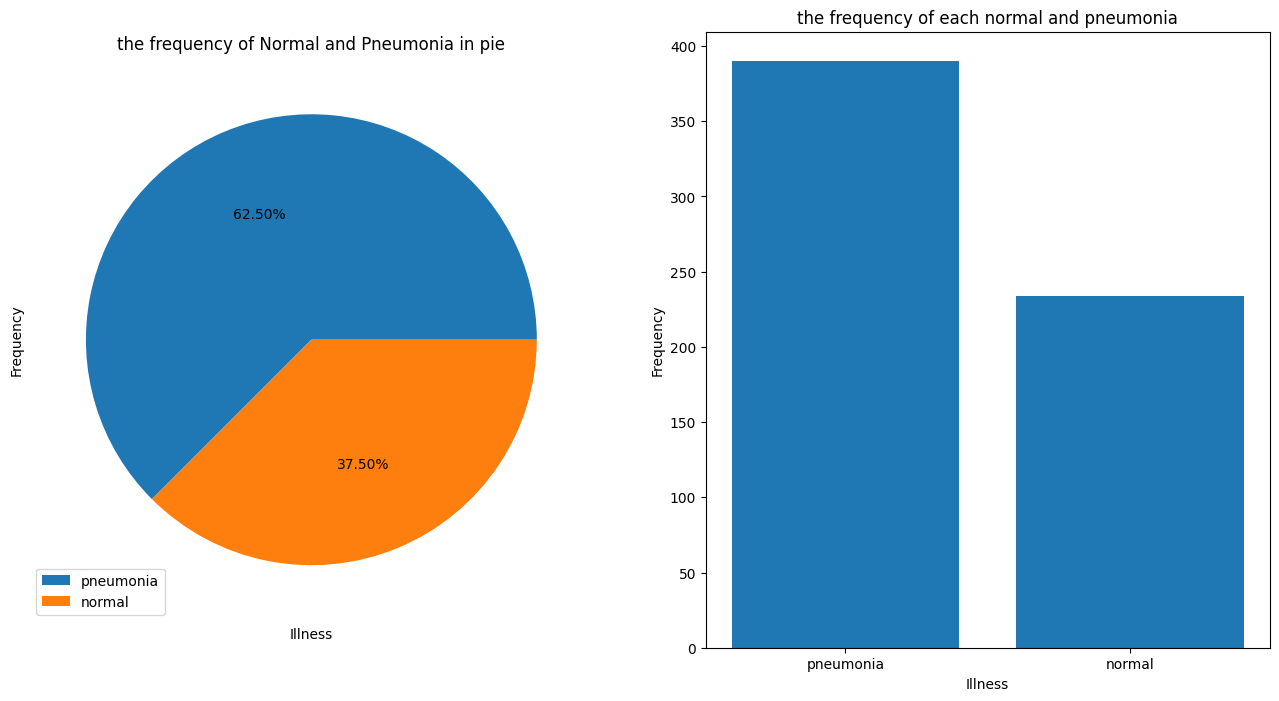

In [64]:
fig = plt.figure(figsize = (16,8))
plt.subplot(121)
plt.pie(df['label'].value_counts(), autopct='%1.2f%%', startangle=0)
plt.xlabel('Illness')
plt.ylabel('Frequency')
plt.title('the frequency of Normal and Pneumonia in pie')
plt.legend(['pneumonia', 'normal'],loc='lower left')
plt.subplot(122)
plt.bar(df['label'].unique(),df['label'].value_counts())
plt.xlabel('Illness')
plt.ylabel('Frequency')
plt.title('the frequency of each normal and pneumonia');

In [19]:
def plot_images(image_path, label, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7))
    num_images= (nrows*ncols)
    for i in range(num_images):
        img = Image.open(image_path[i])
        row_idx, col_idx = divmod(i, ncols)
        axes[row_idx, col_idx].imshow(img,cmap='gray')
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_title(f'{label}\nShape: {img.size}')
    plt.show()
pneumonia_path = train_df.query("label=='pneumonia'")['file'].values
normal_path = train_df.query("label=='normal'")['file'].values

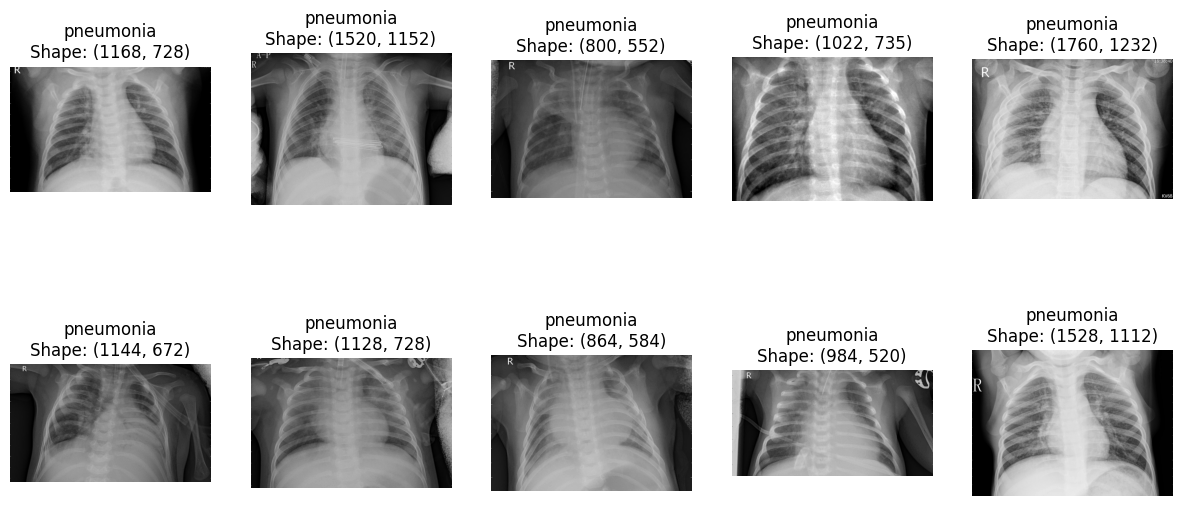

In [20]:
plot_images(pneumonia_path, 'pneumonia')

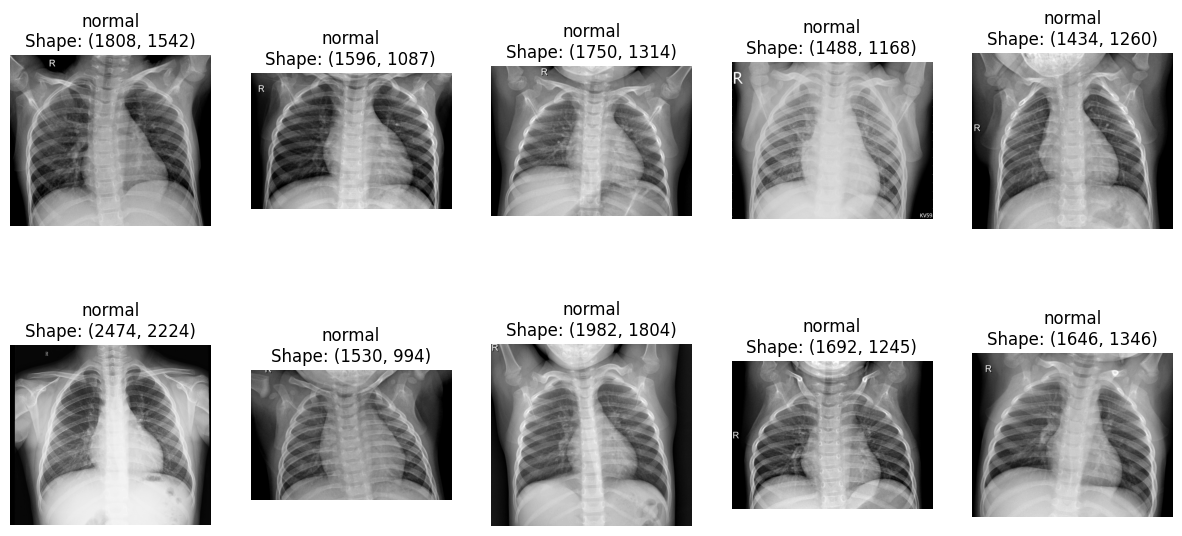

In [21]:
plot_images(normal_path, 'normal')

# Data Preprocessing

In [22]:
def preprocess_image(file_path, label, channels=3):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=channels)
    img = tf.image.resize(img, [224, 224])  
    img = tf.cast(img, tf.float32) / 255.0  
    label = tf.where(tf.math.equal(label, 'normal'), 0, 1)
    return img, label

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32

In [24]:
X_train = []
y_train = []
for i, l in train_df.values:
    image, label = preprocess_image(i,l,channels=3)
    X_train.append(image.numpy())
    y_train.append(label.numpy())
X_train = np.array(X_train)
y_train = np.array(y_train)

In [25]:
X_train.shape

(4099, 224, 224, 3)

In [26]:
y_train.shape

(4099,)

In [27]:
X_test = []
y_test = []
for i, l in test_df.values:
    image, label = preprocess_image(i,l,channels=3)
    X_test.append(image.numpy())
    y_test.append(label.numpy())
X_test = np.array(X_test)
y_test = np.array(y_test)

In [28]:
X_test.shape

(1757, 224, 224, 3)

In [29]:
y_test.shape

(1757,)

-------------------------------

# Building Model

In [30]:
def train_val_eval(history_name=None):
    train_loss = history_name.history['loss']
    val_loss = history_name.history['val_loss']
    train_acc = history_name.history['accuracy']
    val_acc = history_name.history['val_accuracy']
    return train_loss, val_loss, train_acc, val_acc

In [40]:
def plot_training_history(file_name,history_name=None,start_epoch=1):

    train_loss, val_loss, train_acc, val_acc=train_val_eval(history_name)
    range_epoch= np.arange(start_epoch, start_epoch + len(train_loss))
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(range_epoch, train_loss, label='Training Loss')
    plt.plot(range_epoch, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=1))
    plt.yticks(np.arange(0,1.1,.1))
    plt.subplot(2, 1, 2)
    plt.plot(range_epoch, train_acc, label='Training Accuracy')
    plt.plot(range_epoch, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range_epoch) 
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=1))
    plt.yticks(np.arange(0.7,1,.05))
    plt.savefig(f'{file_name}.png')
    plt.show()

In [32]:
def predict_and_evaluate(model, dataset):
    y_true = []
    y_pred = []
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])
    return report

In [33]:
def calculate_confusion_matrix(model, dataset):
    y_true = []
    y_pred = []
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Normal', 'Pneumonia'], 
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('confusion_matrix_of_cnn_model.png')
    plt.show()
    tn, fp, fn, tp = conf_matrix.ravel()
    return tp, fp, tn, fn

In [34]:
def predict_and_evaluate(model, dataset):
    y_true = []
    y_pred = [] 
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])  
    return report

-------------------------------------------------------------------------------------------------------

## CNN Base Model 

In [35]:
model_1= tf.keras.models.Sequential([
    Conv2D(32 , (3,3), activation = 'relu',input_shape = (224, 224, 3)),
    MaxPool2D((2,2)),
    Conv2D(64 , (3,3), activation = 'relu'),
    MaxPool2D((2,2)),
    Conv2D(64 , (3,3), activation = 'relu'),
    MaxPool2D((2,2)),
    Conv2D(128 , (3,3), activation = 'relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
model_1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)       

In [36]:
model_1.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
history_1= model_1.fit(X_train,y_train,batch_size=batch_size, validation_data=(X_test,y_test), epochs=10 ,verbose=1)

Epoch 1/10


129/129 [==============================] - 58s 433ms/step - loss: 0.5822 - accuracy: 0.7229 - val_loss: 0.6562 - val_accuracy: 0.7297
Epoch 2/10
129/129 [==============================] - 53s 412ms/step - loss: 0.5017 - accuracy: 0.7651 - val_loss: 0.7485 - val_accuracy: 0.7297
Epoch 3/10
129/129 [==============================] - 54s 423ms/step - loss: 0.3865 - accuracy: 0.8358 - val_loss: 0.3047 - val_accuracy: 0.8554
Epoch 4/10
129/129 [==============================] - 57s 439ms/step - loss: 0.2990 - accuracy: 0.8785 - val_loss: 0.4630 - val_accuracy: 0.8082
Epoch 5/10
129/129 [==============================] - 65s 501ms/step - loss: 0.2396 - accuracy: 0.9056 - val_loss: 0.2375 - val_accuracy: 0.9118
Epoch 6/10
129/129 [==============================] - 60s 461ms/step - loss: 0.2112 - accuracy: 0.9166 - val_loss: 0.1981 - val_accuracy: 0.9169
Epoch 7/10
129/129 [==============================] - 53s 410ms/step - loss: 0.1826 - accuracy: 0.9312 - val_loss: 0.2479 - val_

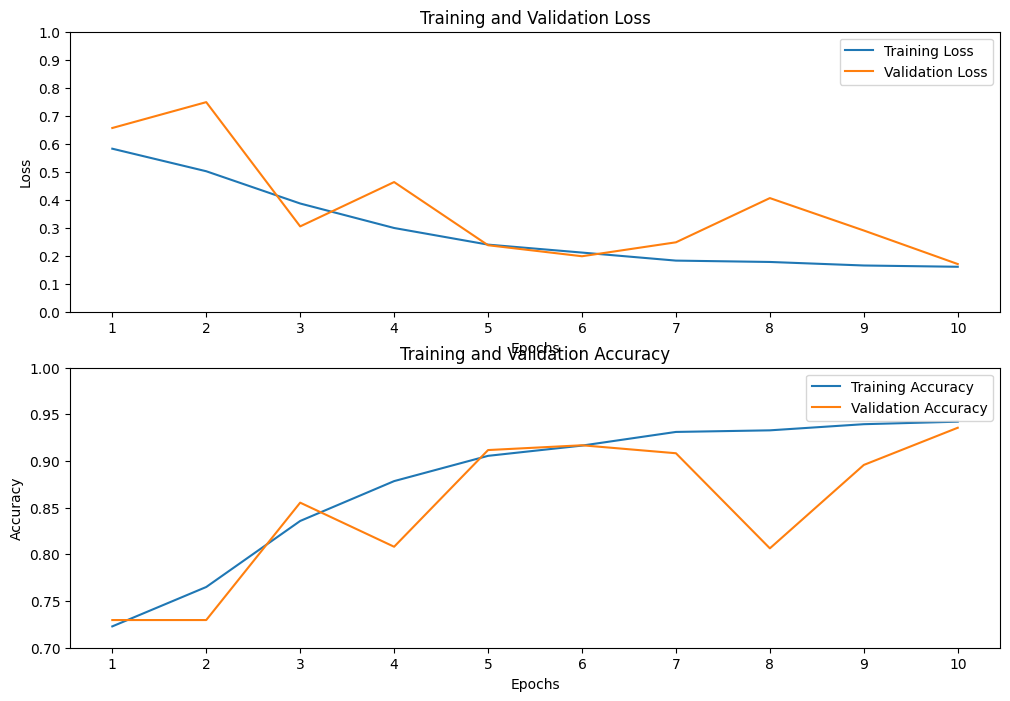

In [41]:
plot_training_history(file_name="base_model",history_name=history_1)

In [42]:
model_1.evaluate(X_test,y_test, verbose=1)

55/55 [==============================] - 5s 84ms/step - loss: 0.1703 - accuracy: 0.9357


[0.17027489840984344, 0.9356858134269714]

-------------------------------------------------------------------------------------------------------

## DNN Model 

In [43]:
Dnn_model = tf.keras.models.Sequential()                   
Dnn_model.add(tf.keras.layers.Flatten(input_shape=(224,224,3)))                 
Dnn_model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu)) 
Dnn_model.add(tf.keras.layers.Dense(64,activation=tf.nn.relu))  
Dnn_model.add(tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)) 
Dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               19267712  
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19276033 (73.53 MB)
Trainable params: 19276033 (73.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
Dnn_model.compile(optimizer=optimizer , loss='binary_crossentropy' , metrics=['accuracy'])    

In [45]:
dnn_history = Dnn_model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=10, verbose=1)

Epoch 1/10
129/129 [==============================] - 15s 105ms/step - loss: 5.5002 - accuracy: 0.7860 - val_loss: 3.1505 - val_accuracy: 0.7063
Epoch 2/10
129/129 [==============================] - 13s 100ms/step - loss: 0.9744 - accuracy: 0.8861 - val_loss: 0.4663 - val_accuracy: 0.9260
Epoch 3/10
129/129 [==============================] - 13s 99ms/step - loss: 0.8361 - accuracy: 0.8853 - val_loss: 1.5241 - val_accuracy: 0.7832
Epoch 4/10
129/129 [==============================] - 13s 99ms/step - loss: 0.4480 - accuracy: 0.9136 - val_loss: 0.6073 - val_accuracy: 0.8583
Epoch 5/10
129/129 [==============================] - 13s 99ms/step - loss: 0.5010 - accuracy: 0.8966 - val_loss: 0.2871 - val_accuracy: 0.9209
Epoch 6/10
129/129 [==============================] - 13s 98ms/step - loss: 0.4409 - accuracy: 0.9036 - val_loss: 0.3800 - val_accuracy: 0.9101
Epoch 7/10
129/129 [==============================] - 13s 101ms/step - loss: 0.2533 - accuracy: 0.9324 - val_loss: 0.7538 - val_accura

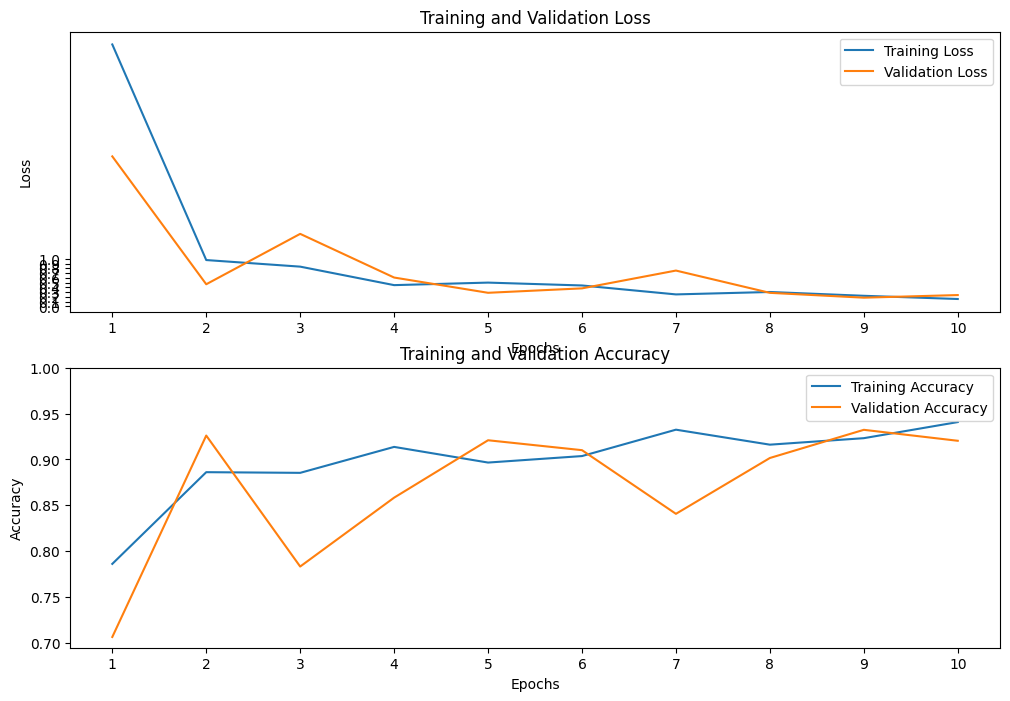

In [46]:
plot_training_history(file_name="DNN_model",history_name=dnn_history)

In [47]:
Dnn_model.evaluate(X_test,y_test, verbose=1)

55/55 [==============================] - 1s 10ms/step - loss: 0.2393 - accuracy: 0.9203


[0.2393488585948944, 0.9203187227249146]

-------------------------------------------------------------------------------------------------------

## Data Augmentation

In [48]:
def augment_train_image(img, label):
    img= color_jitter(img, seed=3)
    return img, label
def augment_val_image(img, label):
    return img, label
layers_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomRotation(0.02),
            tf.keras.layers.RandomZoom(height_factor=(0.05, 0.1),width_factor=(0.05, 0.1)),
        ])

In [49]:
def color_jitter(image, brightness_factor=0.01, contrast_factor=0.01, seed=None):
    image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
    image = tf.image.random_contrast(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_saturation(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_hue(image, max_delta=0.1, seed=seed)
    return image

In [50]:
def prepare(ds, batch_size=32,shuffle=False, layers_aug=False, custom_aug=False):
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    if custom_aug:
        ds = ds.map(augment_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if layers_aug:
        ds = ds.map(lambda x, y: (layers_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

In [51]:
train_image_paths = train_df['file'].values
train_labels = train_df['label'].values
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_ds= prepare(train_dataset, batch_size, shuffle=False, custom_aug=True)
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['file'].values, test_df['label'].values))
test_ds = prepare(test_dataset, batch_size, shuffle=False)

In [52]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)
  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


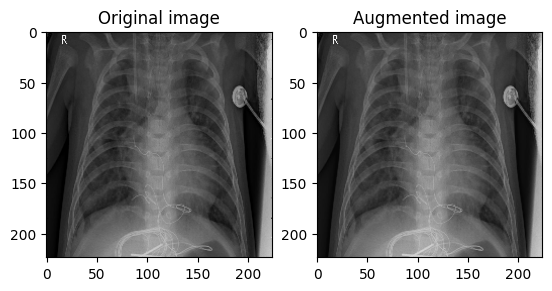

In [53]:
image_path = 'chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg'
img, label = preprocess_image(image_path,'pneumonia',channels=3)
color_jiter_test = color_jitter(img,seed=3)
visualize(img, color_jiter_test);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

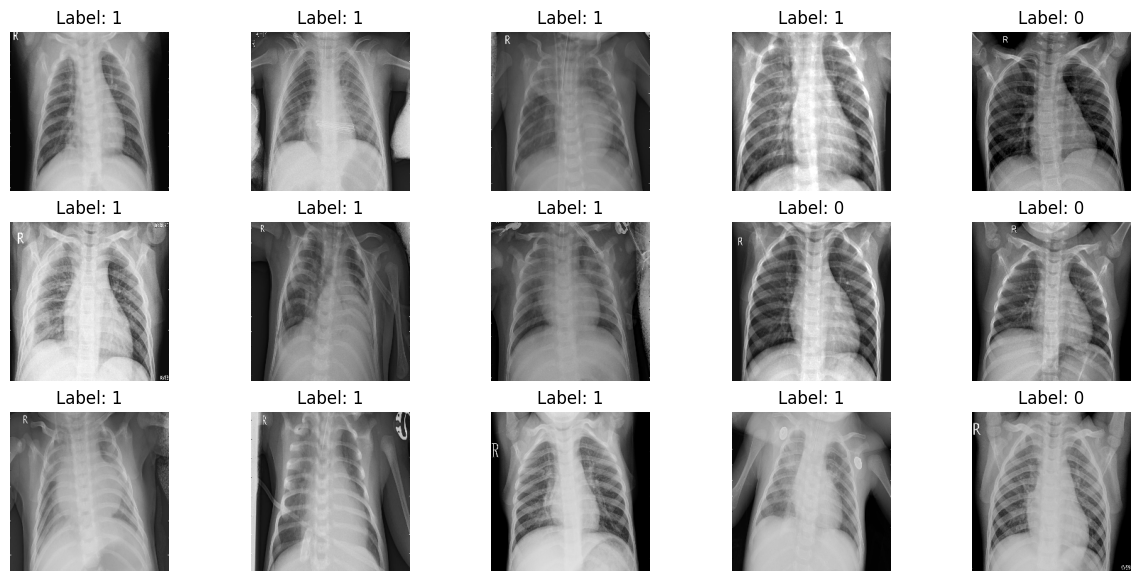

In [54]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(15, 7))
    for i in range(15):
        plt.subplot(3, 5, i + 1) 
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.show();

------------------------------------------------------------------------------------------------------

## CNN Model with Data Augmentation, Dropout

In [55]:
model_2 = tf.keras.models.Sequential([
    Conv2D(32 , (3,3), strides = 1 , kernel_initializer='he_uniform', padding = 'valid' , activation = 'relu',input_shape = (224, 224, 3)),
    MaxPool2D((2,2) , strides = 2 , padding = 'valid'),
    Conv2D(64 , (3,3) , strides = 1, kernel_initializer='he_uniform', padding = 'valid' , activation = 'relu'),
    MaxPool2D((2,2) , strides = 2 , padding = 'valid'),
    Conv2D(64 , (3,3) , strides = 1, kernel_initializer='he_uniform', padding = 'valid' , activation = 'relu'),
    MaxPool2D((2,2) , strides = 2 , padding = 'valid'),
    Conv2D(128 , (3,3), strides = 1, kernel_initializer='he_uniform', padding = 'valid' , activation = 'relu'),
    MaxPool2D((2,2) , strides = 2 , padding = 'valid'),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 64)       

In [56]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
history_2= model_2.fit(train_ds, validation_data=test_ds, epochs=25, verbose=1)

Epoch 1/25
129/129 [==============================] - 59s 444ms/step - loss: 0.4370 - accuracy: 0.8319 - val_loss: 0.1979 - val_accuracy: 0.9209
Epoch 2/25
129/129 [==============================] - 65s 500ms/step - loss: 0.1802 - accuracy: 0.9275 - val_loss: 0.1632 - val_accuracy: 0.9351
Epoch 3/25
129/129 [==============================] - 71s 553ms/step - loss: 0.1546 - accuracy: 0.9444 - val_loss: 0.1590 - val_accuracy: 0.9448
Epoch 4/25
129/129 [==============================] - 64s 498ms/step - loss: 0.1367 - accuracy: 0.9536 - val_loss: 0.1840 - val_accuracy: 0.9328
Epoch 5/25
129/129 [==============================] - 51s 394ms/step - loss: 0.1156 - accuracy: 0.9544 - val_loss: 0.1511 - val_accuracy: 0.9499
Epoch 6/25
129/129 [==============================] - 52s 406ms/step - loss: 0.1139 - accuracy: 0.9576 - val_loss: 0.2937 - val_accuracy: 0.9146
Epoch 7/25
129/129 [==============================] - 51s 398ms/step - loss: 0.1048 - accuracy: 0.9595 - val_loss: 0.1707 - val_ac

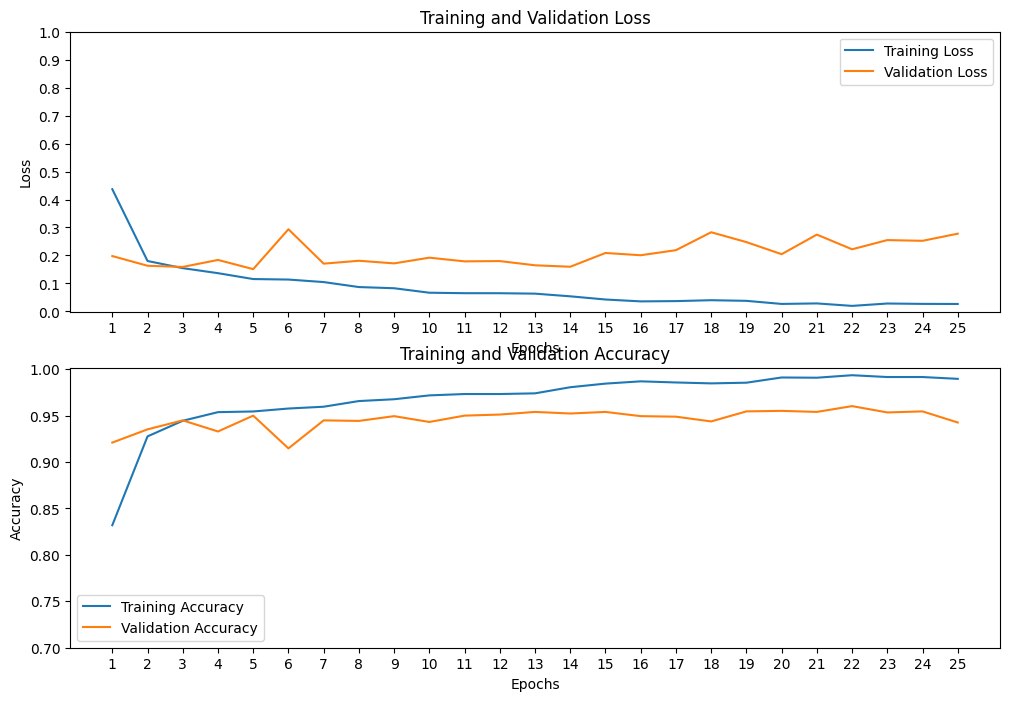

In [58]:
plot_training_history(file_name="improved_CNN_model",history_name=history_2)

In [59]:
model_2.evaluate(test_ds, verbose=1)

55/55 [==============================] - 4s 80ms/step - loss: 0.2778 - accuracy: 0.9425


[0.2778490483760834, 0.9425156712532043]

In [60]:
model_2.save('model_2.keras')

In [61]:
classification_report_2 = predict_and_evaluate(model_2, test_ds)
print(classification_report_2)

              precision    recall  f1-score   support

      normal       0.86      0.95      0.90       475
   pneumonia       0.98      0.94      0.96      1282

    accuracy                           0.94      1757
   macro avg       0.92      0.94      0.93      1757
weighted avg       0.95      0.94      0.94      1757



In [62]:
loaded_model_2 = tf.keras.models.load_model('model_2.keras')

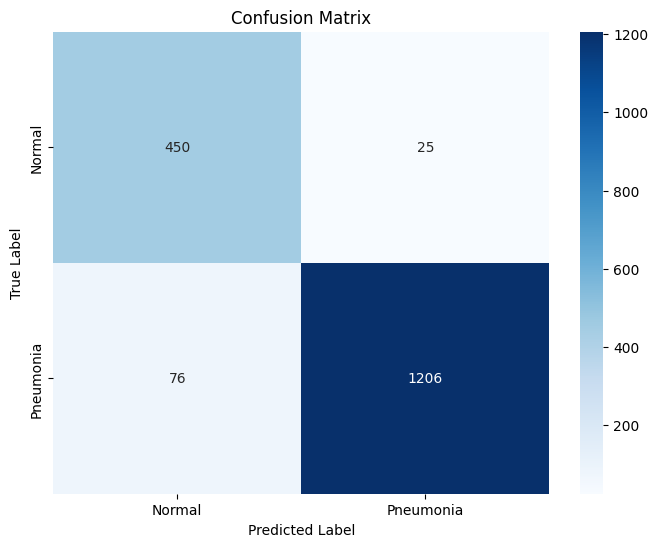

True Positive (TP): 1206
False Positive (FP): 25
True Negative (TN): 450
False Negative (FN): 76


In [63]:
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_2, test_ds)
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

-------------------------------------------------------------------------------------------------------

# GUI App

In [ ]:
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

In [ ]:
def binary_predict_image(model, image_path, threshold=0.5):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array, verbose=0)
    predicted_class_label = 'pneumonia' if prediction[0] > threshold else 'normal'
    try:
        img = Image.open(image_path)
        img = img.resize((250, 250), Image.ANTIALIAS)
        img = ImageTk.PhotoImage(img)
        label = tk.Label(inner_frame, image=img)
        label.image = img
        label.pack()
        result_label = tk.Label(inner_frame, text=predicted_class_label)
        result_label.pack()
    except Exception as e:
        print(f'Error: {e}')

    return predicted_class_label

In [ ]:
def upload_action():
    file_paths = filedialog.askopenfilenames()
    for file_path in file_paths:
        binary_predict_image(loaded_model_2, file_path, 0.4)

def on_configure(event):
    canvas.configure(scrollregion=canvas.bbox('all'))

root = tk.Tk()
root.title("Pneumonia Detection")

canvas = tk.Canvas(root)
scrollbar = tk.Scrollbar(root, command=canvas.yview)
canvas.configure(yscrollcommand=scrollbar.set)
scrollbar.pack(side='right', fill='y')
canvas.pack(side='left', fill='both', expand=True)
inner_frame = tk.Frame(canvas)
canvas.create_window((0, 0), window=inner_frame, anchor='nw')
inner_frame.bind('<Configure>', on_configure)
upload_button = tk.Button(root, text="Upload Images", command=upload_action)
upload_button.pack(pady=20)

root.mainloop()

-------------------------------------------------------------------------------------------------------